In [ ]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload archive.zip here


Saving 4020986 copy.csv.zip to 4020986 copy.csv.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("4020986 copy.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("archive")  # will create archive/train-image/image/ and archive/train-metadata.csv


In [ ]:
weather = pd.read_csv("archive/4020986 copy.csv", index_col = "DATE")


In [ ]:
weather

,STATION,NAME,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,...,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",80.0,90.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",30.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",80.0,100.0,NaN,NaN,NaN,0.02,0.0,0.0,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
1970-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",10.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1970-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",30.0,10.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,16.78,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,7.16,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,8.28,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Data cleaning
# this returns the fraction of null values in each column
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]

In [ ]:
null_pct

,0
STATION,0.000000
NAME,0.000000
ACMH,0.524551
ACSH,0.524502
AWND,0.254413
FMTM,0.499382
PGTM,0.390001
PRCP,0.000049
SNOW,0.000049
SNWD,0.000099


In [ ]:
valid_columns = weather.columns[null_pct < 0.05]

In [ ]:
valid_columns
#Use these features as our predictor variables as these columns have less than 0.5% null values

Index(['STATION', 'NAME', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN'], dtype='object')

In [ ]:
weather = weather[valid_columns].copy()

In [ ]:
weather.columns = weather.columns.str.lower()
weather

,station,name,prcp,snow,snwd,tmax,tmin
DATE,,,,,,,
1970-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,28.0,22.0
1970-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,22.0
1970-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,38.0,25.0
1970-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,23.0
1970-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,35.0,21.0
...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0


In [ ]:
weather = weather.ffill()

In [ ]:
weather.apply(pd.isnull).sum()

,0
station,0
name,0
prcp,0
snow,0
snwd,0
tmax,0
tmin,0


In [ ]:
weather.dtypes

,0
station,object
name,object
prcp,float64
snow,float64
snwd,float64
tmax,float64
tmin,float64


In [ ]:
weather.index = pd.to_datetime(weather.index)

In [ ]:
weather.index.year

Index([1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       ...
       2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
      dtype='int32', name='DATE', length=20223)

In [ ]:
weather.index.year.value_counts().sort_index()

,count
DATE,
1970,365
1971,365
1972,366
1973,365
1974,365
1975,365
1976,366
1977,365
1978,365


<Axes: xlabel='DATE'>

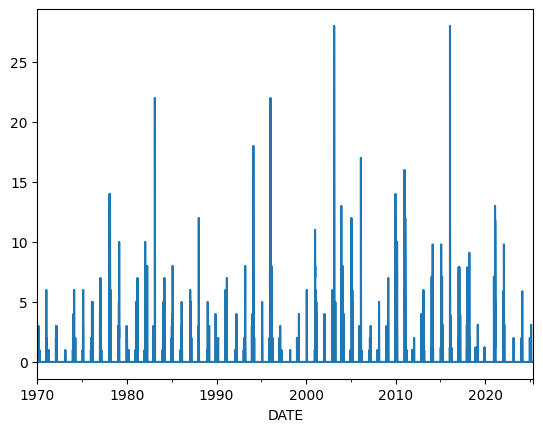

In [ ]:
weather["snwd"].plot()

In [ ]:
weather

,station,name,prcp,snow,snwd,tmax,tmin
DATE,,,,,,,
1970-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,28.0,22.0
1970-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,22.0
1970-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,38.0,25.0
1970-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,23.0
1970-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,35.0,21.0
...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0


In [ ]:
weather["target"] = weather.shift(-1)["tmax"]
# in our model, as we need LABELS/ TRUE values or prior forecasts , we use .shift to pull all the values -1 in the next row of the specified column.

In [ ]:
weather

,station,name,prcp,snow,snwd,tmax,tmin,target
DATE,,,,,,,,
1970-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,28.0,22.0,31.0
1970-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,22.0,38.0
1970-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,38.0,25.0,31.0
1970-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,23.0,35.0
1970-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,35.0,21.0,36.0
...,...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0,79.0
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0,70.0
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0,72.0


In [ ]:
weather = weather.ffill()
#to handle the last NaN target value(yesterday's value) historic data compensates for the error this value might cause.

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
weather.select_dtypes(include=np.number).corr()

,prcp,snow,snwd,tmax,tmin,target
prcp,1.000000,0.146827,0.001074,-0.008307,0.051523,-0.004371
snow,0.146827,1.000000,0.234271,-0.173693,-0.157877,-0.171502
snwd,0.001074,0.234271,1.000000,-0.256511,-0.253346,-0.238040
tmax,-0.008307,-0.173693,-0.256511,1.000000,0.955022,0.914921
tmin,0.051523,-0.157877,-0.253346,0.955022,1.000000,0.914743
target,-0.004371,-0.171502,-0.238040,0.914921,0.914743,1.000000


In [ ]:
rr = Ridge(alpha=.1)
#.1 is a good default for shrinking the coeffecients.


In [ ]:
predictors = weather.columns[~weather.columns.isin(["target","name","station"])]
predictors

Index(['prcp', 'snow', 'snwd', 'tmax', 'tmin'], dtype='object')

In [ ]:
#We cant use normal cross validation in this time-series dataframe as In time series, data has a natural temporal order the future depends on the past. Randomly shuffling and splitting (as in regular K-fold) breaks this order and can cause data leakage

def backtest(weather , model , predictors , start = 3650, step  = 90):
  all_presictions = []

  for i in range(start, weather.shape[0], step):
    train = weather.iloc[:i,:]
    test = weather.iloc[i:(i+step),:]

    model.fit(train[predictors], train["target"])

    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index)
    combined = pd.concat([test["target"], preds], axis = 1)
    combined.columns = ["actual","prediction"]
    combined["diff"]= (combined["prediction"] - combined["actual"]).abs()
    all_presictions.append(combined)
  return pd.concat(all_presictions)
#

In [ ]:
predictions = backtest(weather , rr , predictors)

In [ ]:
predictions

,actual,prediction,diff
DATE,,,
1979-12-30,43.0,50.229324,7.229324
1979-12-31,42.0,43.673798,1.673798
1980-01-01,41.0,41.579150,0.579150
1980-01-02,36.0,43.961887,7.961887
1980-01-03,30.0,40.204726,10.204726
...,...,...,...
2025-05-10,79.0,69.777880,9.222120
2025-05-11,70.0,73.060829,3.060829
2025-05-12,72.0,67.972025,4.027975


In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

5.138642802089364

In [ ]:
predictions["diff"].mean()

np.float64(5.138642802089364)

In [ ]:
def pct_diff(old , new):
  return (new-old) / old

def compute_rolling(weather , horizon , col):
  label = f"rolling_{horizon}_{col}"
  weather[label] = weather[col].rolling(horizon).mean()
  weather[f"{label}_pct"] = pct_diff(weather[label],weather[col])
  return weather

rolling_horizons = [3,14]

for horizon in rolling_horizons :
  for col in ["tmax","tmin","prcp"]:
    weather = compute_rolling (weather , horizon , col)

In [ ]:
weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,rolling_3_tmin_pct,rolling_3_prcp,rolling_3_prcp_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct
DATE,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,28.0,22.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,22.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,38.0,25.0,31.0,32.333333,0.175258,23.000000,0.086957,0.006667,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,31.0,23.0,35.0,33.333333,-0.070000,23.333333,-0.014286,0.006667,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,35.0,21.0,36.0,34.666667,0.009615,23.000000,-0.086957,0.006667,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0,79.0,70.333333,0.052133,54.666667,-0.048780,0.083333,-1.0,70.214286,0.053917,54.285714,-0.042105,0.123571,-1.000000
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0,70.0,72.000000,0.097222,53.333333,0.012500,0.083333,-1.0,71.357143,0.107107,54.642857,-0.011765,0.123571,-1.000000
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0,72.0,74.333333,-0.058296,52.666667,-0.012658,0.000000,NaN,71.000000,-0.014085,54.571429,-0.047120,0.123571,-1.000000


In [ ]:
weather = weather.iloc[14:,:]

In [ ]:
weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,rolling_3_tmin_pct,rolling_3_prcp,rolling_3_prcp_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct
DATE,,,,,,,,,,,,,,,,,,,,
1970-01-15,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,29.0,13.0,36.0,29.666667,-0.022472,18.000000,-0.277778,0.000000,NaN,29.857143,-0.028708,18.857143,-0.310606,0.022857,-1.000000
1970-01-16,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,36.0,21.0,43.0,30.333333,0.186813,16.666667,0.260000,0.000000,NaN,30.214286,0.191489,18.785714,0.117871,0.022857,-1.000000
1970-01-17,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,43.0,30.0,42.0,36.000000,0.194444,21.333333,0.406250,0.006667,2.0,30.571429,0.406542,19.142857,0.567164,0.022857,-0.125000
1970-01-18,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.10,0.0,0.0,42.0,25.0,25.0,40.333333,0.041322,25.333333,-0.013158,0.040000,1.5,31.357143,0.339408,19.285714,0.296296,0.030000,2.333333
1970-01-19,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,25.0,16.0,24.0,36.666667,-0.318182,23.666667,-0.323944,0.040000,-1.0,30.642857,-0.184149,18.928571,-0.154717,0.030000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0,79.0,70.333333,0.052133,54.666667,-0.048780,0.083333,-1.0,70.214286,0.053917,54.285714,-0.042105,0.123571,-1.000000
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0,70.0,72.000000,0.097222,53.333333,0.012500,0.083333,-1.0,71.357143,0.107107,54.642857,-0.011765,0.123571,-1.000000
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0,72.0,74.333333,-0.058296,52.666667,-0.012658,0.000000,NaN,71.000000,-0.014085,54.571429,-0.047120,0.123571,-1.000000


In [ ]:
weather = weather.fillna(0)

In [ ]:
def expand_mean(df):
  return df.expanding(1).mean()
for col in ["tmax","tmin","prcp"] :
  weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month,group_keys=False).apply(expand_mean)
  weather[f"day_avg_{col}"]= weather[col].groupby(weather.index.day_of_year,group_keys=False).apply(expand_mean)


In [ ]:
weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-15,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,29.0,13.0,36.0,29.666667,-0.022472,...,18.857143,-0.310606,0.022857,-1.000000,29.000000,29.000000,13.000000,13.000000,0.000000,0.000000
1970-01-16,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,36.0,21.0,43.0,30.333333,0.186813,...,18.785714,0.117871,0.022857,-1.000000,32.500000,36.000000,17.000000,21.000000,0.000000,0.000000
1970-01-17,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.02,0.0,0.0,43.0,30.0,42.0,36.000000,0.194444,...,19.142857,0.567164,0.022857,-0.125000,36.000000,43.000000,21.333333,30.000000,0.006667,0.020000
1970-01-18,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.10,0.0,0.0,42.0,25.0,25.0,40.333333,0.041322,...,19.285714,0.296296,0.030000,2.333333,37.500000,42.000000,22.250000,25.000000,0.030000,0.100000
1970-01-19,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,25.0,16.0,24.0,36.666667,-0.318182,...,18.928571,-0.154717,0.030000,-1.000000,35.000000,25.000000,21.000000,16.000000,0.024000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,74.0,52.0,79.0,70.333333,0.052133,...,54.285714,-0.042105,0.123571,-1.000000,68.634402,67.446429,53.122449,51.589286,0.124385,0.166429
2025-05-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,79.0,54.0,70.0,72.000000,0.097222,...,54.642857,-0.011765,0.123571,-1.000000,68.640443,67.232143,53.122960,51.732143,0.124312,0.076429
2025-05-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,70.0,52.0,72.0,74.333333,-0.058296,...,54.571429,-0.047120,0.123571,-1.000000,68.641235,68.178571,53.122306,52.107143,0.124240,0.127857


In [ ]:
predictors = weather.columns[~weather.columns.isin(["target","name","station"])]

In [ ]:
predictors

Index(['prcp', 'snow', 'snwd', 'tmax', 'tmin', 'rolling_3_tmax',
       'rolling_3_tmax_pct', 'rolling_3_tmin', 'rolling_3_tmin_pct',
       'rolling_3_prcp', 'rolling_3_prcp_pct', 'rolling_14_tmax',
       'rolling_14_tmax_pct', 'rolling_14_tmin', 'rolling_14_tmin_pct',
       'rolling_14_prcp', 'rolling_14_prcp_pct', 'month_avg_tmax',
       'day_avg_tmax', 'month_avg_tmin', 'day_avg_tmin', 'month_avg_prcp',
       'day_avg_prcp'],
      dtype='object')

In [ ]:
predictions = backtest(weather, rr, predictors)

In [ ]:
predictions.sort_values("diff", ascending =False)

,actual,prediction,diff
DATE,,,
1990-03-12,85.0,54.361065,30.638935
2007-03-26,78.0,49.965413,28.034587
1998-03-26,80.0,51.966675,28.033325
2003-04-15,86.0,59.432179,26.567821
1985-04-18,84.0,58.425960,25.574040
...,...,...,...
1987-09-16,75.0,75.001185,0.001185
1984-08-10,83.0,82.999179,0.000821
2011-09-25,78.0,77.999237,0.000763


In [ ]:
mean_absolute_error(predictions["actual"], predictions["prediction"])

4.78908305314826

In [ ]:
weather.loc["1990-03-07" : "1990-03-17"]

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1990-03-07,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,2.0,32.0,14.0,39.0,33.666667,-0.049505,...,25.000000,-0.440000,0.047857,-1.000000,48.590112,45.428571,34.567783,31.857143,0.119410,0.111429
1990-03-08,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,1.0,39.0,20.0,43.0,35.000000,0.114286,...,24.071429,-0.169139,0.040714,-1.000000,48.574841,46.571429,34.544586,31.190476,0.119220,0.076667
1990-03-09,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.01,0.0,0.0,43.0,29.0,47.0,38.000000,0.131579,...,22.785714,0.272727,0.031429,-0.681818,48.565978,45.619048,34.535771,30.952381,0.119046,0.036190
1990-03-10,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.01,0.0,0.0,47.0,39.0,59.0,43.000000,0.093023,...,23.428571,0.664634,0.020714,-0.517241,48.563492,43.809524,34.542857,31.761905,0.118873,0.071905
1990-03-11,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.05,0.0,0.0,59.0,41.0,59.0,49.666667,0.187919,...,25.500000,0.607843,0.021429,1.333333,48.580032,46.142857,34.553090,31.904762,0.118764,0.126667
1990-03-12,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,59.0,43.0,85.0,55.000000,0.072727,...,27.928571,0.539642,0.021429,-1.000000,48.596519,48.142857,34.566456,34.285714,0.118576,0.167619
1990-03-13,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,85.0,41.0,62.0,67.666667,0.256158,...,29.500000,0.389831,0.020000,-1.000000,48.654028,48.761905,34.576619,34.285714,0.118389,0.091429
1990-03-14,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,62.0,46.0,55.0,68.666667,-0.097087,...,30.857143,0.490741,0.020000,-1.000000,48.675079,50.190476,34.594637,36.809524,0.118202,0.259524
1990-03-15,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,55.0,43.0,62.0,67.333333,-0.183168,...,32.214286,0.334812,0.020000,-1.000000,48.685039,49.714286,34.607874,35.761905,0.118016,0.066667


In [ ]:
predictions["diff"].round().value_counts().sort_index()

,count
diff,
0.0,1211
1.0,2296
2.0,2109
3.0,1937
4.0,1705
5.0,1456
6.0,1228
7.0,1068
8.0,854


<Axes: xlabel='diff'>

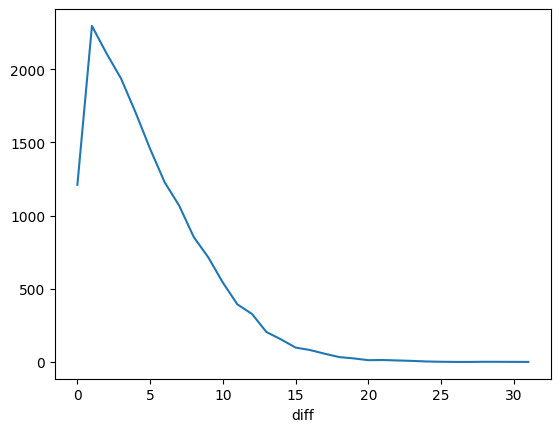

In [ ]:
predictions["diff"].round().value_counts().sort_index().plot()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost MSE: 37.0553
XGBoost MAE: 4.7538


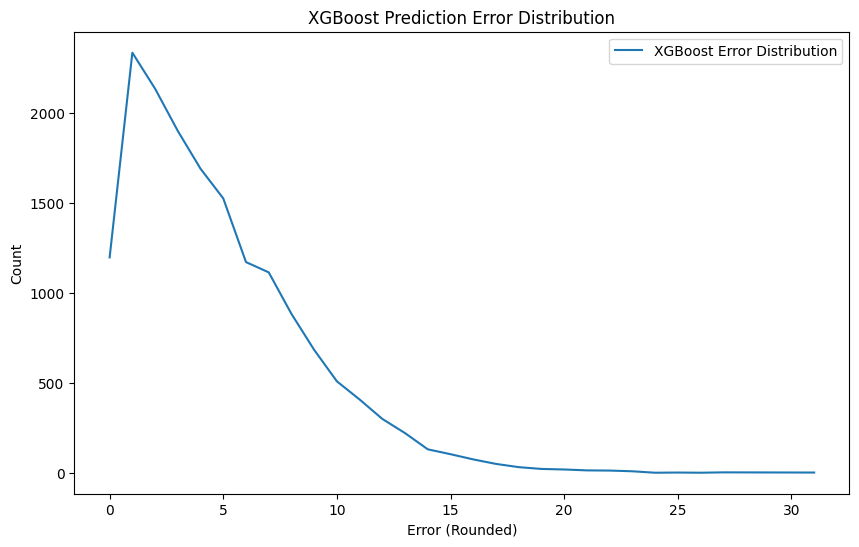

In [ ]:

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Perform Grid Search with a small subset of data for speed
train_subset = weather.iloc[:3650, :]
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(train_subset[predictors], train_subset["target"])

# Best model
best_xgb = grid_search.best_estimator_
print("Best XGBoost Parameters:", grid_search.best_params_)

# Backtest with best XGBoost model
xgb_predictions = backtest(weather, best_xgb, predictors, start=3650, step=90)

# Compute MSE and MAE
xgb_mse = mean_squared_error(xgb_predictions["actual"], xgb_predictions["prediction"])
xgb_mae = mean_absolute_error(xgb_predictions["actual"], xgb_predictions["prediction"])
print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")

# Plot prediction errors
plt.figure(figsize=(10, 6))
xgb_predictions["diff"].round().value_counts().sort_index().plot(label="XGBoost Error Distribution")
plt.title("XGBoost Prediction Error Distribution")
plt.xlabel("Error (Rounded)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
def backtest_lstm(weather, predictors, seq_length=10, start=3650, step=90):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i + step), :]
        X_train, y_train = create_sequences(train, predictors, "target", seq_length)
        X_test, y_test = create_sequences(test, predictors, "target", seq_length)
        if len(X_train) == 0 or len(X_test) == 0:
            continue
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(seq_length, len(predictors)), return_sequences=True),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            verbose=0,
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
        )
        preds = model.predict(X_test, verbose=0).flatten()
        preds_index = test.index[seq_length:len(preds) + seq_length]
        combined = pd.DataFrame({
            "actual": test["target"].iloc[seq_length:len(preds) + seq_length],
            "prediction": preds
        }, index=preds_index)
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)
    return pd.concat(all_predictions)

<ipython-input-55-90ad70170ef4>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([last_weather, result.to_frame().T], axis=0, ignore_index=False)
<ipython-input-55-90ad70170ef4>:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_df.loc[date, predictors] = future_df.loc[date, predictors].fillna(0.0)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
<ipython-input-55-90a

10-Day tmax Predictions (May 15, 2025 - May 24, 2025):
            ridge_prediction  xgb_prediction
date                                        
2025-05-15         72.271572       70.474098
2025-05-16         71.593885       70.821587
2025-05-17         71.732411       70.810265
2025-05-18         71.637554       70.120743
2025-05-19         71.436178       70.132065
2025-05-20         71.820654       70.854691
2025-05-21         71.984598       70.854691
2025-05-22         72.175776       71.395401
2025-05-23         72.291153       71.395401
2025-05-24         72.416724       71.395401


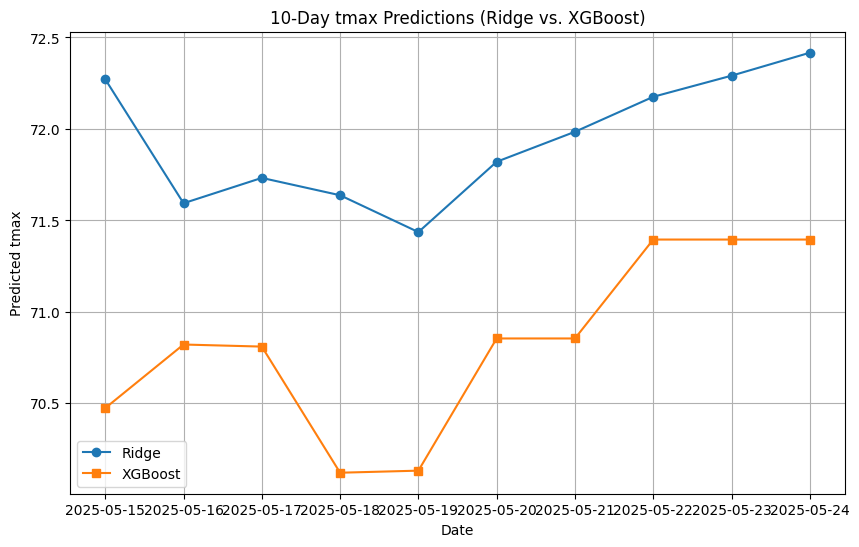

In [ ]:
# 10-Day Predictions for Ridge and XGBoost (May 15, 2025 - May 24, 2025)
from datetime import timedelta
import pandas as pd
import numpy as np

# Train models on all available data
rr.fit(weather[predictors], weather["target"])
best_xgb.fit(weather[predictors], weather["target"])

# Initialize DataFrame for future predictions (May 15 to May 24, 2025)
future_dates = pd.date_range(start="2025-05-15", end="2025-05-24", freq="D")
future_df = pd.DataFrame(index=future_dates, columns=weather.columns)
future_df[predictors] = 0.0  # Initialize with zeros instead of NaN

# Initialize with last known values from weather (May 14, 2025)
last_row = weather.iloc[-1].copy()
for col in ["tmax", "tmin", "prcp"]:
    future_df[col] = last_row[col]  # Use last known values as baseline

# Function to update derived features (rolling and expanding means, percentage differences)
def update_features(df_row, last_weather, predictors, current_date):
    result = df_row.copy()

    # Combine last weather data with prior predictions for feature computation
    combined = pd.concat([last_weather, result.to_frame().T], axis=0, ignore_index=False)
    combined.index = pd.to_datetime(combined.index)

    # Update rolling features
    for horizon in [3, 14]:
        for col in ["tmax", "tmin", "prcp"]:
            label = f"rolling_{horizon}_{col}"
            rolling_mean = combined[col].rolling(horizon, min_periods=1).mean().loc[current_date]
            result[label] = rolling_mean if not pd.isna(rolling_mean) else last_row.get(label, 0.0)
            result[f"{label}_pct"] = 0.0 if rolling_mean == 0 or pd.isna(rolling_mean) else (result[col] - rolling_mean) / rolling_mean

    # Update monthly and day-of-year expanding means
    for col in ["tmax", "tmin", "prcp"]:
        # Monthly expanding mean
        month = current_date.month
        month_data = last_weather[last_weather.index.month == month][col]
        result[f"month_avg_{col}"] = month_data.expanding(1).mean().iloc[-1] if len(month_data) > 0 else last_row.get(f"month_avg_{col}", 0.0)

        # Day-of-year expanding mean
        doy = current_date.timetuple().tm_yday
        doy_data = last_weather[last_weather.index.dayofyear == doy][col]
        result[f"day_avg_{col}"] = doy_data.expanding(1).mean().iloc[-1] if len(doy_data) > 0 else last_row.get(f"day_avg_{col}", 0.0)

    return result

# Generate predictions for each day
predictions_10_days = {
    "date": future_dates,
    "ridge_prediction": [],
    "xgb_prediction": []
}

for i, date in enumerate(future_dates):
    # Update features for the current day
    if i == 0:
        future_df.loc[date] = update_features(
            future_df.loc[date], weather.iloc[:-1], predictors, date
        )
    else:
        combined_weather = pd.concat([weather.iloc[:-1], future_df.iloc[:i]], axis=0)
        future_df.loc[date] = update_features(
            future_df.loc[date], combined_weather, predictors, date
        )

    # Fill any remaining NaN values
    future_df.loc[date, predictors] = future_df.loc[date, predictors].fillna(0.0)

    # Predict tmax
    features = future_df.loc[date][predictors].values.reshape(1, -1)
    ridge_pred = rr.predict(features)[0]
    xgb_pred = best_xgb.predict(features)[0]

    predictions_10_days["ridge_prediction"].append(ridge_pred)
    predictions_10_days["xgb_prediction"].append(xgb_pred)

    # Update tmax for the next iteration (use Ridge prediction for simplicity)
    # future_df.loc[date, "tmax"] = ridge_pred
    # if i < len(future_dates) - 1:
    #     next_date = future_dates[i + 1]
    #     future_df.loc[next_date, "tmax"] = last_row["tmax"]  # Reset for next iteration
    future_df.loc[date, "tmax"] = ridge_pred
# Do NOT reset next_date's tmax to last_row["tmax"]
# The next iteration will use the updated value in future_df


# Create final predictions DataFrame
predictions_df = pd.DataFrame(predictions_10_days)
predictions_df["date"] = pd.to_datetime(predictions_df["date"])
predictions_df.set_index("date", inplace=True)

# Display predictions
print("10-Day tmax Predictions (May 15, 2025 - May 24, 2025):")
print(predictions_df)

# Save to CSV for reference
predictions_df.to_csv("10_day_predictions.csv")

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df["ridge_prediction"], label="Ridge", marker="o")
plt.plot(predictions_df.index, predictions_df["xgb_prediction"], label="XGBoost", marker="s")
plt.title("10-Day tmax Predictions (Ridge vs. XGBoost)")
plt.xlabel("Date")
plt.ylabel("Predicted tmax")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Optimized LSTM Model with Manual Tuning
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Function to prepare data for LSTM (sequences)
def create_sequences(data, predictors, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[predictors].iloc[i:(i + seq_length)].values)
        y.append(data[target].iloc[i + seq_length])
    return np.array(X), np.array(y)

# Scale features
scaler = StandardScaler()
weather_scaled = weather.copy()
weather_scaled[predictors] = scaler.fit_transform(weather[predictors])

# Define optimized LSTM backtest function
def backtest_lstm(weather, predictors, seq_length=5, start=3650, step=90):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i + step), :]

        # Create sequences
        X_train, y_train = create_sequences(train, predictors, "target", seq_length)
        X_test, y_test = create_sequences(test, predictors, "target", seq_length)

        # Skip if not enough data
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        # Define simpler LSTM model
        model = Sequential([
            LSTM(32, activation='relu', input_shape=(seq_length, len(predictors))),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=64,
            verbose=0,
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
        )

        # Predict
        preds = model.predict(X_test, verbose=0, batch_size=64).flatten()
        preds_index = test.index[seq_length:len(preds) + seq_length]
        combined = pd.DataFrame({
            "actual": test["target"].iloc[seq_length:len(preds) + seq_length],
            "prediction": preds
        }, index=preds_index)
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)

    return pd.concat(all_predictions)

# Run LSTM backtest
seq_length = 5
lstm_predictions = backtest_lstm(weather_scaled, predictors, seq_length=seq_length)

# Compute MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
lstm_mse = mean_squared_error(lstm_predictions["actual"], lstm_predictions["prediction"])
lstm_mae = mean_absolute_error(lstm_predictions["actual"], lstm_predictions["prediction"])
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")

# Plot prediction errors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
lstm_predictions["diff"].round().value_counts().sort_index().plot(label="LSTM Error Distribution")
plt.title("LSTM Prediction Error Distribution")
plt.xlabel("Error (Rounded)")
plt.ylabel("Count")
plt.legend()
plt.show()